In [1]:
%pylab inline
import iam_hdf5_iterator


Populating the interactive namespace from numpy and matplotlib


In [65]:
def plot_shingles(batch, nr_to_plot, nr_per_row=3):
    nr_rows = nr_to_plot // nr_per_row + min(nr_to_plot % nr_per_row, 1)
    for row_i in range(nr_rows):
        for col_i in range(nr_per_row):
            subplot_cell_id = row_i * nr_per_row + col_i + 1
            # handle partial final row case
            if subplot_cell_id > nr_to_plot:
                break
            
            batch_img = batch[subplot_cell_id-1]
            
            plt.subplot(nr_rows, nr_per_row, subplot_cell_id)
            plt.imshow(-batch_img, cmap="gray")
            plt.gca().axes.get_xaxis().set_ticks([])
            plt.gca().axes.get_yaxis().set_ticks([])

def main():
    shingle_size=(120,120)
    batch_size=32
    
    print "Sampling demo."
    print "Each batch should be different within iterations and identical across iterations."
    for iter_i in range(2):
        print "Iteration {0}.................".format(iter_i+1)
        iam_iterator = iam_hdf5_iterator.IAM_MiniBatcher("/fileserver/iam/iam-processed/lines/author_lines.hdf5", 
                                                     100, 5, use_form=True,
                                                     shingle_dim=shingle_size,
                                                     batch_size=batch_size)
    
        print "First nine: "
        mb = iam_iterator.get_train_batch()
        plt.figure(figsize=(9,3))
        plot_shingles(mb[0], 6, 6)
        plt.show()
        print "Next nine: "
        mb2 = iam_iterator.get_train_batch()
        plt.figure(figsize=(9,3))
        plot_shingles(mb2[0], 6, 6)
        plt.show()

    print "No repeats demo"
    print "The probability of a repeated shingle in a single epoch should be very small."
    iam_iterator = iam_hdf5_iterator.IAM_MiniBatcher("/fileserver/iam/iam-processed/lines/author_lines.hdf5", 
                                                     100, 5, use_form=True,
                                                     shingle_dim=shingle_size,
                                                     batch_size=batch_size)
    nr_iters = 5
    unique_imgs = set()
    for i in range(nr_iters):
        print "Batch {0}".format(i)
        mb = iam_iterator.get_train_batch()
        plt.figure(figsize=(9,9))
        plot_shingles(mb[0], batch_size, 6)
        plt.show()
        unique_imgs.update([mb[0][img_i].tostring() for img_i in range(batch_size)])
        print "**Unique images so far: {0} (should be {1})**".format(len(unique_imgs), (i+1) * batch_size)
        
    
    

Sampling demo.
Each batch should be different within iterations and identical across iterations.
Iteration 1.................
First nine: 


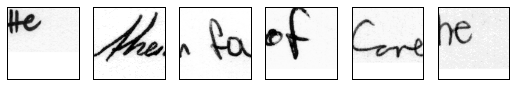

Next nine: 


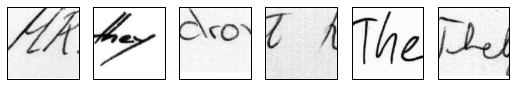

Iteration 2.................
First nine: 


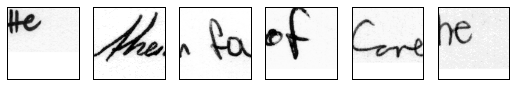

Next nine: 


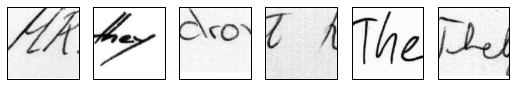

No repeats demo
The probability of a repeated shingle in a single epoch should be very small.
Batch 0


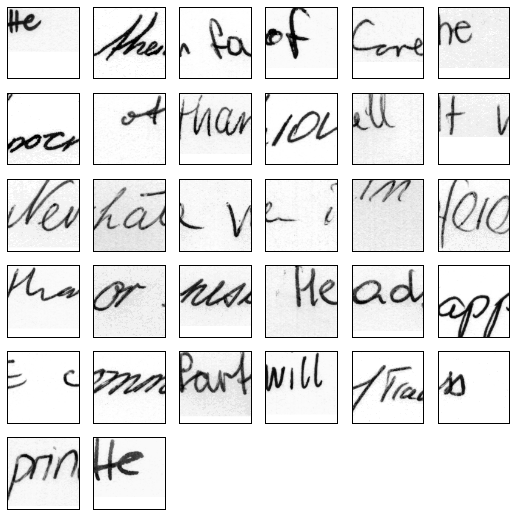

**Unique images so far: 32 (should be 32)**
Batch 1


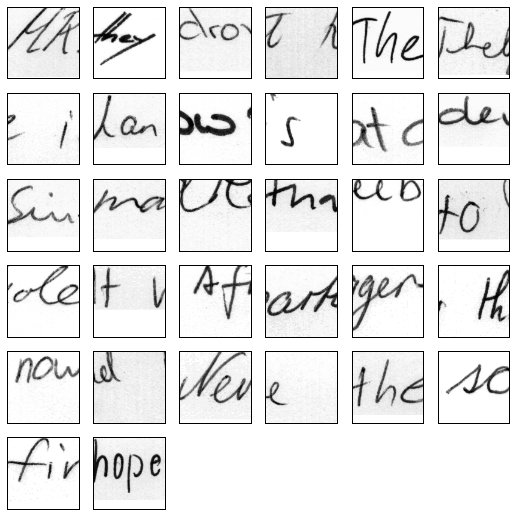

**Unique images so far: 62 (should be 64)**
Batch 2


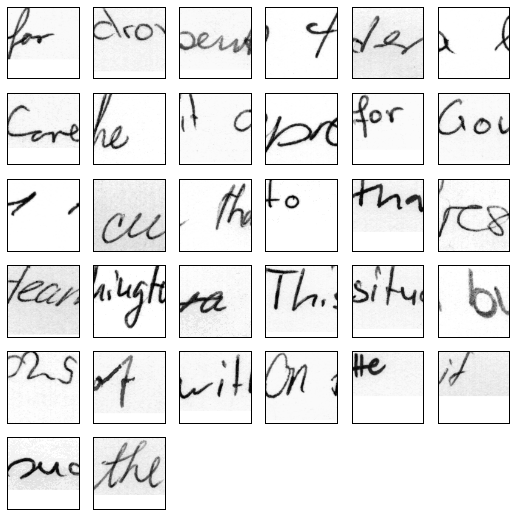

**Unique images so far: 90 (should be 96)**
Batch 3


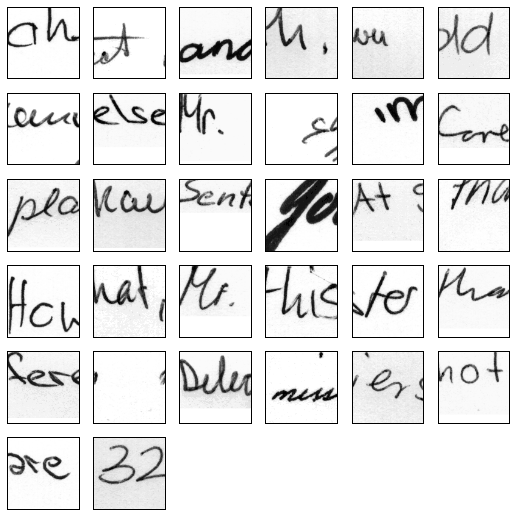

**Unique images so far: 120 (should be 128)**
Batch 4


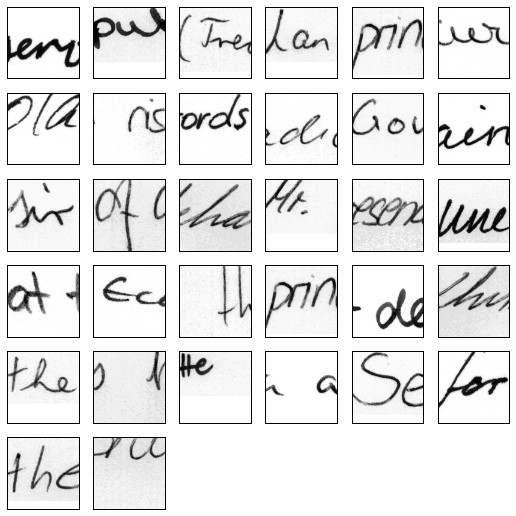

**Unique images so far: 146 (should be 160)**


In [66]:
# Main Test Cell
main()

In [54]:
mb[0][0]

NameError: name 'mb' is not defined

In [58]:
hash("tweet")

-646121437820297174